In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
LABELS = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 128
BATCH_SIZE = 32

In [3]:
# Step 4: Create directory to save models
if not os.path.isdir('models_/'):
    os.mkdir("models_/")
    print("Created directory for model weights")

Created directory for model weights


In [4]:
def get_data(data_dir):
    # Initialize empty lists for images and labels
    images = []
    labels = []
    
    print(f"Loading data from {data_dir}...")
    
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        print(f"Processing {label} images...")
        
        # Count files for progress indication
        file_count = len(os.listdir(path))
        processed = 0
        
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Skip if image couldn't be read
                if img_arr is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                    
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                images.append(resized_arr)
                labels.append(class_num)
                
                # Update progress
                processed += 1
                if processed % 300 == 0:
                    print(f"Processed {processed}/{file_count} {label} images")
                
            except Exception as e:
                print(f"Error processing {img}: {e}")
    
    # Convert lists to numpy arrays
    X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = np.array(labels)
    
    print(f"Loaded {len(images)} images from {data_dir}")
    print(f"Data shape: X={X.shape}, y={y.shape}")
    
    return X, y

In [5]:
# Step 6: Load the dataset
print("\n=== Loading Dataset ===")
X_train, y_train = get_data(f"{BASE_DIR}/train")
X_val, y_val = get_data(f"{BASE_DIR}/val")
X_test, y_test = get_data(f"{BASE_DIR}/test")



=== Loading Dataset ===
Loading data from /kaggle/input/chest-xray-pneumonia/chest_xray/train...
Processing PNEUMONIA images...
Processed 300/3875 PNEUMONIA images
Processed 600/3875 PNEUMONIA images
Processed 900/3875 PNEUMONIA images
Processed 1200/3875 PNEUMONIA images
Processed 1500/3875 PNEUMONIA images
Processed 1800/3875 PNEUMONIA images
Processed 2100/3875 PNEUMONIA images
Processed 2400/3875 PNEUMONIA images
Processed 2700/3875 PNEUMONIA images
Processed 3000/3875 PNEUMONIA images
Processed 3300/3875 PNEUMONIA images
Processed 3600/3875 PNEUMONIA images
Processing NORMAL images...
Processed 300/1341 NORMAL images
Processed 600/1341 NORMAL images
Processed 900/1341 NORMAL images
Processed 1200/1341 NORMAL images
Loaded 5216 images from /kaggle/input/chest-xray-pneumonia/chest_xray/train
Data shape: X=(5216, 128, 128, 1), y=(5216,)
Loading data from /kaggle/input/chest-xray-pneumonia/chest_xray/val...
Processing PNEUMONIA images...
Processing NORMAL images...
Loaded 16 images f

In [6]:
# Step 7: Normalize pixel values
print("\n=== Normalizing Data ===")
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0
print("Normalization complete")


=== Normalizing Data ===
Normalization complete


In [7]:
# Step 8: Count class distribution
print("\n=== Class Distribution ===")
train_pneumonia = np.sum(y_train == 0)
train_normal = np.sum(y_train == 1)
val_pneumonia = np.sum(y_val == 0)
val_normal = np.sum(y_val == 1)
test_pneumonia = np.sum(y_test == 0)
test_normal = np.sum(y_test == 1)

print(f"Training set: {train_pneumonia} Pneumonia, {train_normal} Normal")
print(f"Validation set: {val_pneumonia} Pneumonia, {val_normal} Normal")
print(f"Test set: {test_pneumonia} Pneumonia, {test_normal} Normal") 


=== Class Distribution ===
Training set: 3875 Pneumonia, 1341 Normal
Validation set: 8 Pneumonia, 8 Normal
Test set: 390 Pneumonia, 234 Normal



=== Visualizing Sample Images ===


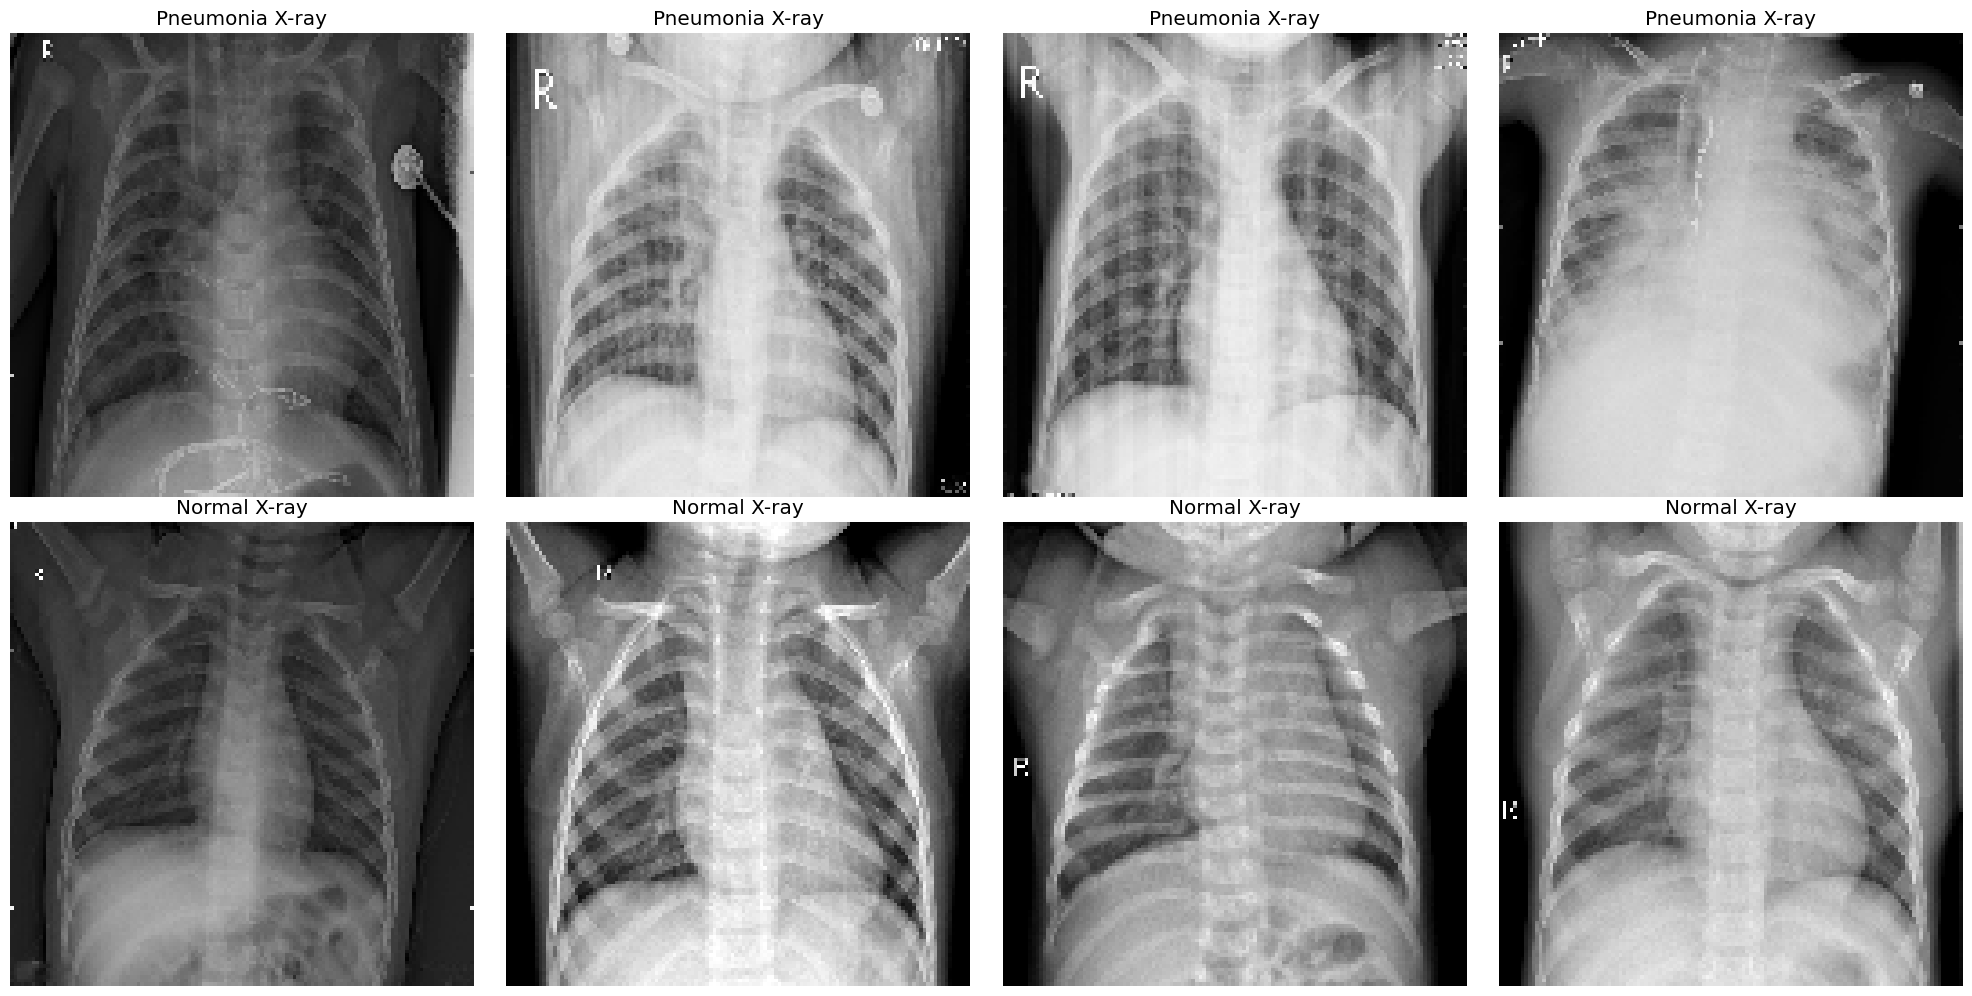

In [8]:
print("\n=== Visualizing Sample Images ===")
plt.figure(figsize=(20, 10))

for i in range(8):
    if i < 4:
        # Plot pneumonia samples
        idx = np.where(y_train == 0)[0][i]
        plt.subplot(2, 4, i+1)
        plt.imshow(X_train[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title('Pneumonia X-ray')
    else:
        # Plot normal samples
        idx = np.where(y_train == 1)[0][i-4]
        plt.subplot(2, 4, i+1)
        plt.imshow(X_train[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title('Normal X-ray')
    plt.axis('off')

plt.tight_layout()
plt.show()



=== Plotting Class Distribution ===


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


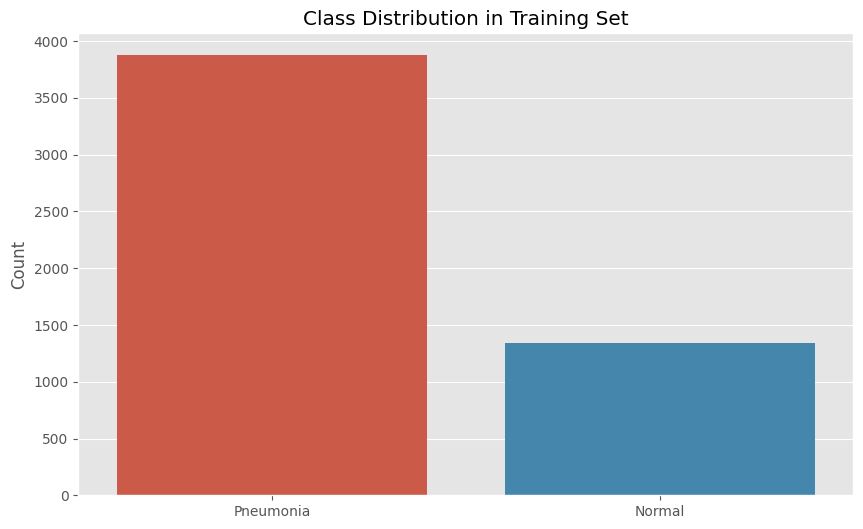

In [9]:
# Step 10: Plot class distribution
print("\n=== Plotting Class Distribution ===")
plt.figure(figsize=(10, 6))
sns.barplot(x=['Pneumonia', 'Normal'], y=[train_pneumonia, train_normal])
plt.title('Class Distribution in Training Set')
plt.ylabel('Count')
plt.show()

In [10]:
# Step 11: Import TensorFlow libraries
print("\n=== Setting Up TensorFlow ===")
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input



=== Setting Up TensorFlow ===


2025-04-22 15:31:16.659973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745335876.843922      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745335876.896791      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# Step 12: Convert labels to categorical format
print("\n=== Converting Labels to Categorical ===")
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)
print("Conversion complete")



=== Converting Labels to Categorical ===
Conversion complete


In [22]:
print("\n=== Defining CNN Architecture ===")
def create_cnn_model():
    model = Sequential([

        Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')  # 2 classes: PNEUMONIA and NORMAL
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
model = create_cnn_model()
model.summary()


=== Defining CNN Architecture ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,068,130 (65.11 MB)

 Trainable params: 17,066,658 (65.10 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [23]:
# Step 14: Define callbacks for training
print("\n=== Setting Up Training Callbacks ===")
filepath = "model_weights/cnn_pneumonia_model.keras"
checkpoint = ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=9,
    verbose=1,
    min_lr=0.00001
)


=== Setting Up Training Callbacks ===


In [24]:
# Step 15: Train the model
print("\n=== Training CNN Model ===")
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,  # We'll use early stopping
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)



=== Training CNN Model ===
Epoch 1/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8255 - loss: 0.4978
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_weights/cnn_pneumonia_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8260 - loss: 0.4964 - val_accuracy: 0.5000 - val_loss: 3.9499 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9253 - loss: 0.2215
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9254 - loss: 0.2215 - val_accuracy: 0.5000 - val_loss: 3.0534 - learning_rate: 1.0000e-04
Epoch 3/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9361 - loss: 0.1760
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9362 - loss: 0.1759 - val_accuracy: 0.5000 - val_loss: 2.2596 - learning_rate: 1.0000e-04
Epoch 4/50
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accura

In [25]:
# Step 16: Save the trained model
print("\n=== Saving Model ===")
model.save("models_/final_cnn_pneumonia_model.h5")
print("Model saved successfully!")


=== Saving Model ===
Model saved successfully!



=== Plotting Training History ===


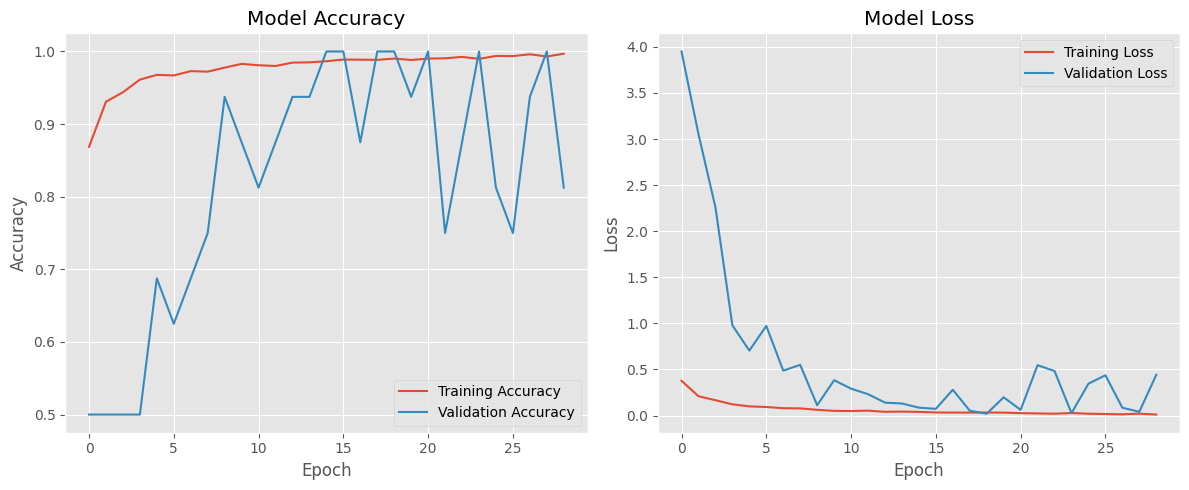

In [26]:
# Step 17: Plot training history
print("\n=== Plotting Training History ===")
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Step 18: Evaluate on test set
print("\n=== Evaluating Model ===")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


=== Evaluating Model ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9324 - loss: 0.2613
Test Loss: 0.6931
Test Accuracy: 0.8429



=== Making Predictions ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

=== Confusion Matrix ===


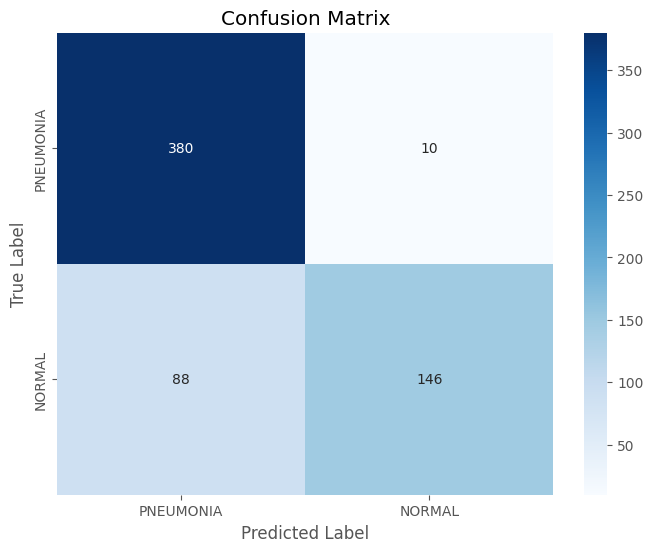


=== Classification Report ===
              precision    recall  f1-score   support

   PNEUMONIA       0.81      0.97      0.89       390
      NORMAL       0.94      0.62      0.75       234

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624


=== Visualizing Predictions ===


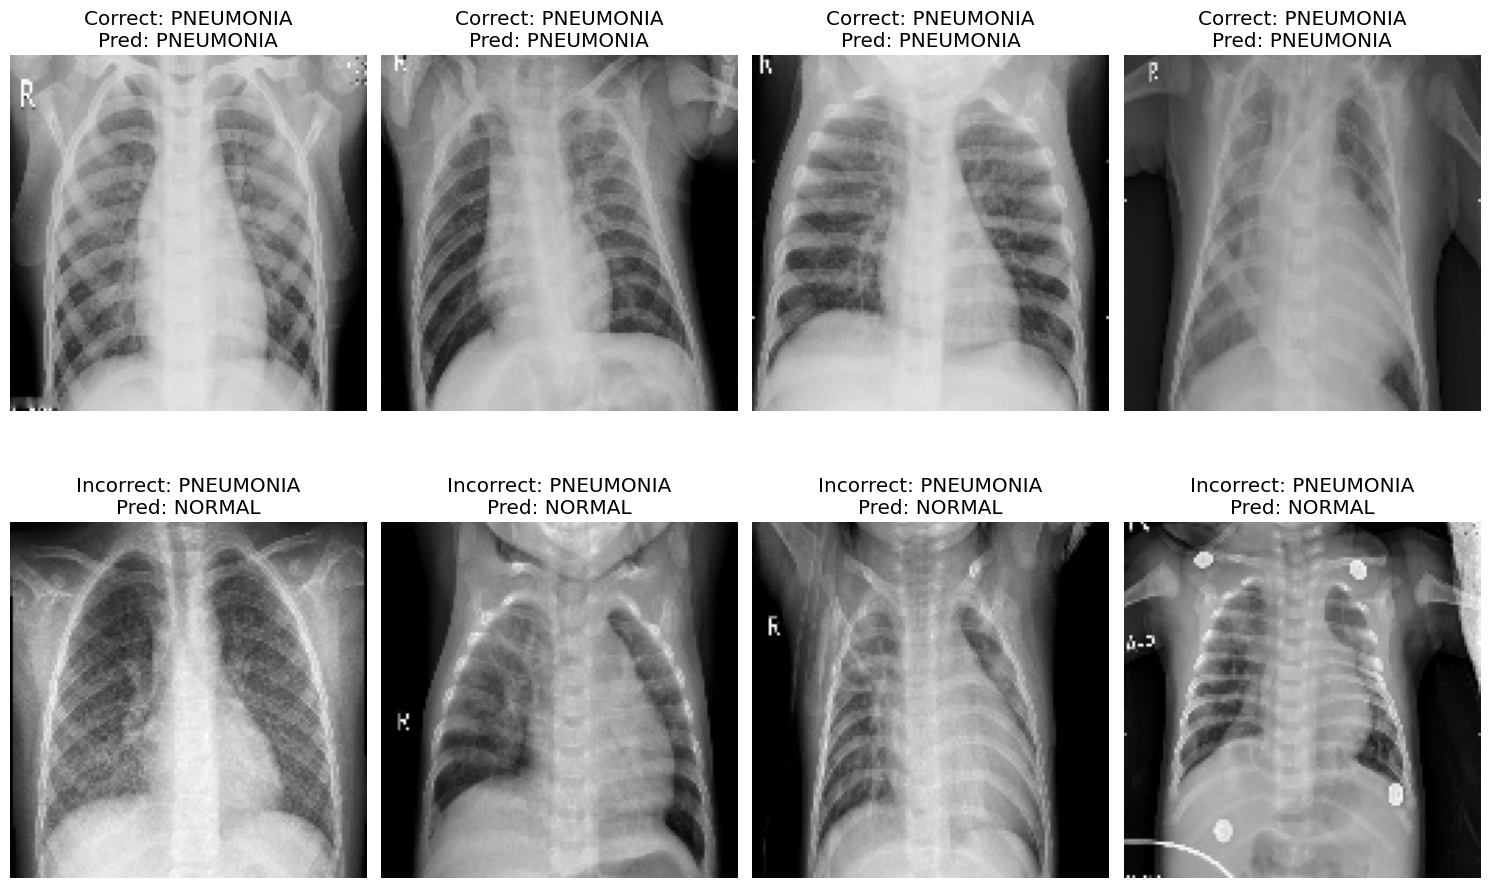


=== Analysis Complete ===
The custom CNN model has been trained and evaluated.


In [28]:
# Step 19: Make predictions
print("\n=== Making Predictions ===")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Step 20: Confusion matrix
print("\n=== Confusion Matrix ===")
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABELS, yticklabels=LABELS)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 21: Classification report
print("\n=== Classification Report ===")
cr = classification_report(y_true, y_pred_classes, target_names=LABELS)
print(cr)

# Step 22: Visualize some predictions
print("\n=== Visualizing Predictions ===")
plt.figure(figsize=(15, 10))

# Plot some correct and incorrect predictions
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Plot 4 correct predictions
for i in range(4):
    plt.subplot(2, 4, i+1)
    idx = correct_indices[i]
    plt.imshow(X_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    pred_label = LABELS[y_pred_classes[idx]]
    true_label = LABELS[y_true[idx]]
    plt.title(f"Correct: {true_label}\nPred: {pred_label}")
    plt.axis('off')

# Plot 4 incorrect predictions
for i in range(4):
    if i < len(incorrect_indices):
        plt.subplot(2, 4, i+5)
        idx = incorrect_indices[i]
        plt.imshow(X_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        pred_label = LABELS[y_pred_classes[idx]]
        true_label = LABELS[y_true[idx]]
        plt.title(f"Incorrect: {true_label}\nPred: {pred_label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("\n=== Analysis Complete ===")
print("The custom CNN model has been trained and evaluated.")